# Prediction of stock prices using time-series analysis

## Business task:
    Identification of volatility and prediction of stock prices

## Datasource description:

Public datasets from Yahoo finance

Our dataset will contain 8 columns: Open, High, Low, Close, Volume, Dividends and Stock split

Date: data is available until the current moment

## Getting data:

In [304]:
#Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima_model import ARIMA
import warnings
from pmdarima.arima import auto_arima

In [305]:
warnings.filterwarnings("ignore")

In [306]:
#Define the stock
tickerSymbol = 'GOOG'
tickerData = yf.Ticker(tickerSymbol)

In [307]:
#get historical data of Google stock
df = tickerData.history(period='1d',start = '2005-1-1', end ='2021-10-8')

In [308]:
print(df)

                   Open         High          Low        Close    Volume  \
Date                                                                       
2004-12-31    99.243011    99.566795    95.920464    96.035034  15394487   
2005-01-03    98.331429   101.439781    97.365051   100.976517  31807176   
2005-01-04   100.323959   101.086105    96.378746    96.886841  27614921   
2005-01-05    96.363808    98.082359    95.756081    96.393692  16534946   
2005-01-06    97.175758    97.584229    93.509506    93.922951  20852067   
...                 ...          ...          ...          ...       ...   
2021-10-01  2671.090088  2741.419922  2667.550049  2729.250000   1419400   
2021-10-04  2713.989990  2714.000000  2623.330078  2675.300049   1576500   
2021-10-05  2680.000000  2747.239990  2680.000000  2723.540039   1206300   
2021-10-06  2692.510010  2757.040039  2689.729980  2747.080078    988200   
2021-10-07  2777.260010  2803.089111  2771.260010  2783.709961    912500   

           

## Data modeling: volatility

First step is to check current volatility. We will use difference between two close prices

In [248]:
# % of price between one day and the next one
returns = 100 * df.Close.pct_change().dropna()

Text(0.5, 1.0, 'Google Returns')

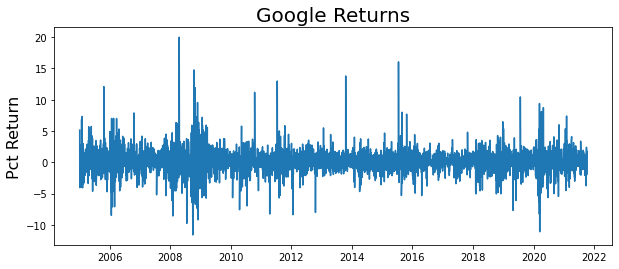

In [249]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Pct Return', fontsize=16)
plt.title('Google Returns', fontsize=20)

As we can see this stock is quite volatile. So, GARCH model can be a good candidate to use for forecast (catch volatility)

In order to find the correct parameters for the model we will use PACF (Partial Auto-correlation function)

### PACF

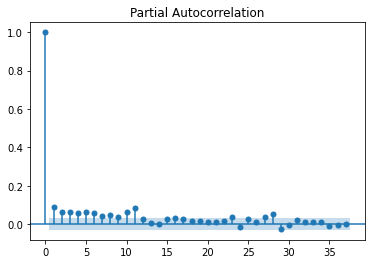

In [309]:
plot_pacf(returns**2)
plt.show()

To not complicate the model, we will use GARCH(1,1). Plus as we can see the value is decreasing on 2, so 1 looks like a good candidate for the model parameter.

### Model build: GARCH(1,1)

In [310]:
#Define GARCH(1,1)
model = arch_model(returns, p=1, q=1)

In [311]:
#Fit the model
model_fit = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19449.373403539306
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1421619.867366583
Iteration:      3,   Func. Count:     24,   Neg. LLF: 9826.88042725609
Iteration:      4,   Func. Count:     32,   Neg. LLF: 8995.179724146947
Iteration:      5,   Func. Count:     39,   Neg. LLF: 8248.704012838818
Iteration:      6,   Func. Count:     45,   Neg. LLF: 8247.276306591113
Iteration:      7,   Func. Count:     50,   Neg. LLF: 8247.15743003905
Iteration:      8,   Func. Count:     55,   Neg. LLF: 8247.153316941596
Iteration:      9,   Func. Count:     60,   Neg. LLF: 8247.151739967254
Iteration:     10,   Func. Count:     65,   Neg. LLF: 8247.15153086017
Iteration:     11,   Func. Count:     70,   Neg. LLF: 8247.15149851995
Iteration:     12,   Func. Count:     74,   Neg. LLF: 8247.151498522122
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8247.15149851995
            Iterations: 12
     

In [312]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8247.15
Distribution:                  Normal   AIC:                           16502.3
Method:            Maximum Likelihood   BIC:                           16527.7
                                        No. Observations:                 4221
Date:                Sat, Oct 09 2021   Df Residuals:                     4220
Time:                        16:49:45   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1141  2.557e-02      4.463  8.074e-06 [6.400e-02,  0.164]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1254  7.045e-02      1.780  7.501e-02 [-1.265e-02,  0.264]
alpha[1]       0.0811  3.588e-02      2.260  2.382e-02  [1.077e-02,  0.151]
beta[1]        0.8851  4.981e-02     17.769  1.219e-70    [  0.787,  0.983]
===========================================================================

Covariance estimator: robust
"""

Model looks good: all coefficients are significant.

In order to improve the prediction, we will use rolling predictions

### Rolling predictions

In [313]:
#rolling prediction
rolling_predictions = []
test_size = 365*3

for i in range(test_size):
    train = returns[:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [314]:
rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-365*3:])

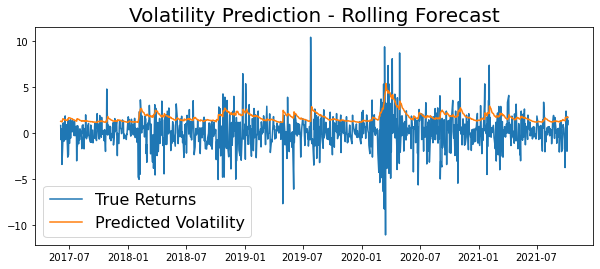

In [315]:
plt.figure(figsize=(10,4))
true, = plt.plot(returns[-365*3:])
preds, = plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)

We were able to catch the volatility of the stock

## Data modeling: stock price forecast

Before we move to stock price forecast, it is worth to do a time series analysis

In [316]:
#Get the historical data
ddf = tickerData.history(period='1d',start = '2019-1-1', end ='2021-10-8')

In [317]:
#Select only open prices
ddf = ddf.asfreq(pd.infer_freq(ddf.index))

In [318]:
ddf['Open'] = ddf['Close'].ffill()
ddf = ddf.bfill(axis=1)

In [319]:
prices = ddf.Open

Text(0, 0.5, 'Price')

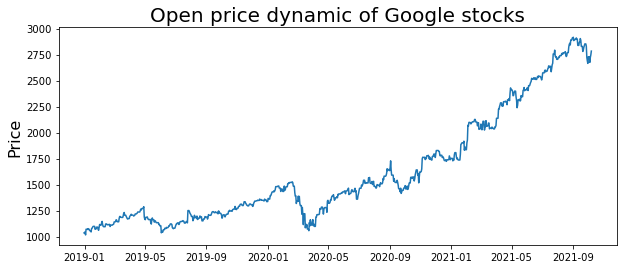

In [320]:
plt.figure(figsize=(10,4))
plt.plot(prices)
plt.title('Open price dynamic of Google stocks', fontsize=20)
plt.ylabel('Price', fontsize=16)

We can clearly see the trend. In this case, ARIMA can be a good candidate for stock price modeling

Let's check stationarity. For this we will use Augmented Dickey–Fuller test

### Stationarity

In [321]:
def ADF_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [322]:
ADF_test(prices)

ADF Statistic: 0.528945
p-value: 0.985727


Obviously the time-series is not stationary. 

To dive deeper, we will do a decomposition

### Decomposition 

In [323]:
stl = STL(prices)
result = stl.fit()

In [324]:
seasonal, trend, resid = result.seasonal, result.trend, result.resid

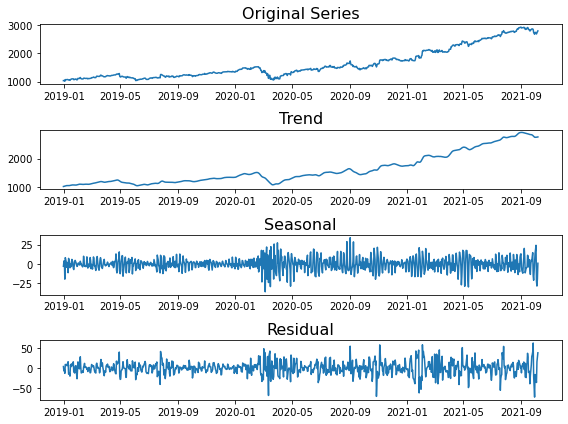

In [325]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(prices)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

No seasonality, what is logical, but we can clearly see trend. 

So, we can conclude that ARIMA model should work in our case. In order to find parameters for the model, we will check the first difference on stationarity and perform a ACF and PACF

### Work with first difference

In [326]:
first_diff = prices.diff()[1:]

Text(0.5, 1.0, 'Difference between current and next prices')

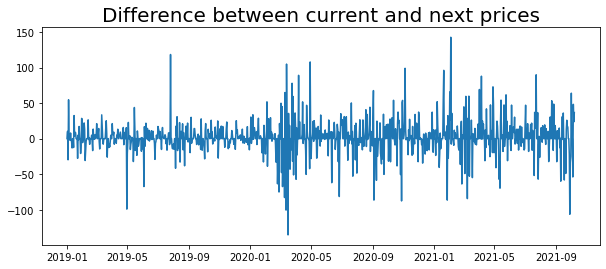

In [327]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Difference between current and next prices', fontsize=20)

In [328]:
#Stationarity test
ADF_test(first_diff)

ADF Statistic: -7.794715
p-value: 0.000000


Test showed that time series is stationary. Hence, d=1. One parameter is defined.

### Building a Auto-correlation function

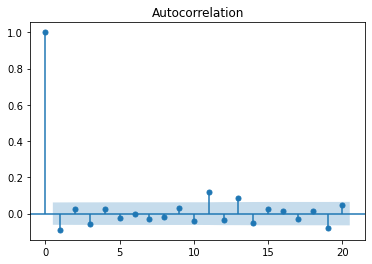

In [329]:
acf_plot = plot_acf(first_diff, lags=20)

1 looks like a good candidate => MA(1)

### Building a Partial Auto-correlation function

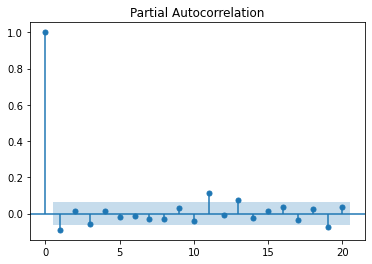

In [330]:
pacf_plot = plot_pacf(first_diff, lags=20)

1 looks like a good candidate => AR(1)

### ARIMA Model (1,1,1)

In [331]:
#GET test and train sets (start = '2019-1-1', end ='2021-10-8')
train_end = datetime(2021,7,1)
test_end = datetime(2021,10,8)

train_data = prices[:train_end]
test_data = prices[train_end + timedelta(days=1):test_end]

In [332]:
#Define model
model = ARIMA(train_data, order=(1,1,1))

In [333]:
#Fitting the model
model_fit = model.fit()

In [334]:
print(model_fit.summary()) 

                             ARIMA Model Results                              
Dep. Variable:                 D.Open   No. Observations:                  913
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4162.279
Method:                       css-mle   S.D. of innovations             23.103
Date:                Sat, 09 Oct 2021   AIC                           8332.557
Time:                        16:53:35   BIC                           8351.824
Sample:                    01-01-2019   HQIC                          8339.913
                         - 07-01-2021                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.6334      0.716      2.282      0.022       0.231       3.036
ar.L1.D.Open    -0.5441      0.234     -2.330      0.020      -1.002      -0.086
ma.L1.D.Open     0.4453      0.250      1.78

In [335]:
#get the predictions
fc, se, conf = model_fit.forecast(len(test_data))

In [336]:
predictions = pd.Series(fc,index=test_data.index)

Text(0.5, 1.0, 'Open price dynamic of Google stocks')

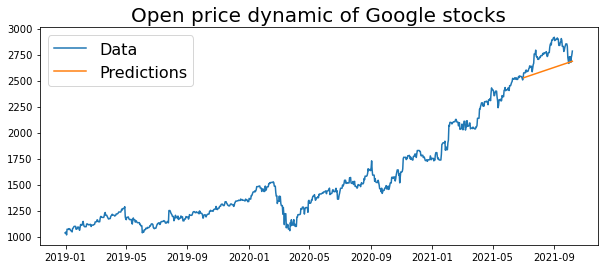

In [337]:
plt.figure(figsize=(10,4))

plt.plot(prices)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Open price dynamic of Google stocks', fontsize=20)

### Model quality check

In [338]:
#Let's check the quality of the model
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0539


In [339]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 168.9977195210578


Overall, we caught the trend, but still it is a bit far from the true prices

### Rolling forecast

In [340]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = prices[:train_end-timedelta(days=1)]
    model = ARIMA(train_data, order=(1,1,1))
    model_fit = model.fit()

    t,c,pred = model_fit.forecast()
    rolling_predictions[train_end] = t

Text(0.5, 1.0, 'Open price dynamic of Google stocks')

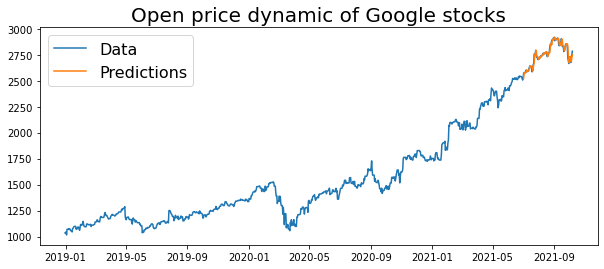

In [341]:
plt.figure(figsize=(10,4))

plt.plot(prices)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Open price dynamic of Google stocks', fontsize=20)

### Model quality check

In [342]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 27.435852705767754


In [343]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0066


We can see that with rolling forecast we were able to achieve better results: now we can catch changes in price. 
It is also clear if we look at error indicators: they decreased significantly